## Conclusion from SQL and panda pre analysis
### Observation
* The code of a control area is unique. A control area will only have one unit and multiple SCPs but units may be duplicate among stations. Linename is messy. => Just use Control Area
* Time is not consistent too. => Use morning/afternoon/night...
* Get needed columns to save almost 100 mb
* Can keep desc-recovered but will need to clean duplicate data with both regular and recovered

### Completed
* Query data from database
* Clean duplicate data with both regular and recovered
* Create datetime frame
* Substract entries and exits to get the numbers
* Clean data
* Substract entries and exits by time
* Daily data analysis
* MVP

### To do
* Busiest CA and Time analysis

# 1. Data Preparation

In [1]:
#*****need to run*****
from sqlalchemy import create_engine
#from sqlalchemy import inspect
import pandas as pd
import numpy as np
#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
#*****need to run*****
engine = create_engine("sqlite:///mta.db")

In [255]:
#*****need to run*****
#df = pd.read_sql('SELECT ca, scp, station, date, time, desc, entries, exits FROM mta_data;', engine)
df = pd.read_sql('''SELECT ca, scp, station, date, time, desc, entries, exits FROM mta_data
                    WHERE date NOT IN ("02/27/2021", "02/28/2021", "06/01/2021", 
                                       "06/02/2021", "06/03/2021", "06/04/2021")
                    ORDER BY ca, date, time, scp, desc;''', engine)

In [4]:
#*****need to run*****
df["o_index"] = df.index
df["o_index"]
#drop duplicate data with wrong recover audit first
mask_dup = df[(df["o_index"] == 300706) |
          (df["o_index"] == 1089956) |
          (df["o_index"] == 1382146) |
          (df["o_index"] == 1382154) |
          ((df["CA"] == "N100") &
           (df["SCP"] == "00-00-00") &
           (df["ENTRIES"] == 818272) &
           (df["o_index"] != 842617))].index
df.drop(mask_dup, inplace= True)
#then, drop duplicate data with wrong regular data
df.drop_duplicates(subset=["CA", "SCP", "STATION", "DATE", "TIME"], keep= 'last', inplace=True)
df.drop(['o_index'], axis = 1, inplace = True)
df.reset_index(drop = True, inplace = True)
#datatime series
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")
df["DAY"] = df["DATE_TIME"].dt.weekday
#period calculation
df.sort_values(["CA", "SCP","DATE_TIME"], inplace=True)
df["PRE_ENTRIES"] = df.ENTRIES.shift(1)
df["PRE_EXITS"] = df.EXITS.shift(1)
df["PRE_TIME"] = df.DATE_TIME.shift(1)
df["PERIOD_ENTRIES"] = df.ENTRIES.diff(1)
df["PERIOD_EXITS"] = df.EXITS.diff(1)
#clean data
df.dropna(inplace=True)
df.drop(df[(df["PERIOD_ENTRIES"] < 0) | (df["PERIOD_EXITS"] < 0)].index, inplace=True)
df.drop(df[(df["DATE_TIME"] < df["PRE_TIME"])].index, inplace=True)
df.drop(df[((df["CA"] == "PTH03") & (df["SCP"] == "00-01-08") & (df["PRE_EXITS"] == 0.0))].index, inplace=True)
df.drop(df[(df["DATE_TIME"] - df["PRE_TIME"] > timedelta(days = 1))].index, inplace=True)
df.drop(df[(df["PERIOD_ENTRIES"] > 10000) | (df["PERIOD_EXITS"] > 10000)].index, inplace=True)
df["PERIOD_VISITS"] = df["PERIOD_ENTRIES"] + df["PERIOD_EXITS"]
df.reset_index(drop = True, inplace = True)
df[["PERIOD_ENTRIES", "PERIOD_EXITS", "PERIOD_VISITS"]] = (
    df[["PERIOD_ENTRIES", "PERIOD_EXITS", "PERIOD_VISITS"]].astype(int))

In [5]:
df.head(3)

,CA,SCP,STATION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DAY,PRE_ENTRIES,PRE_EXITS,PRE_TIME,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS
0,A002,02-00-00,59 ST,03/01/2021,07:00:00,REGULAR,7537862,2570742,2021-03-01 07:00:00,0,7537860.0,2570718.0,2021-03-01 03:00:00,2,24,26
1,A002,02-00-00,59 ST,03/01/2021,11:00:00,REGULAR,7537914,2570858,2021-03-01 11:00:00,0,7537862.0,2570742.0,2021-03-01 07:00:00,52,116,168
2,A002,02-00-00,59 ST,03/01/2021,15:00:00,REGULAR,7538016,2570907,2021-03-01 15:00:00,0,7537914.0,2570858.0,2021-03-01 11:00:00,102,49,151


In [6]:
df.describe()

,ENTRIES,EXITS,DAY,PRE_ENTRIES,PRE_EXITS,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS
count,2.712197e+06,2.712197e+06,2.712197e+06,2.712197e+06,2.712197e+06,2.712197e+06,2.712197e+06,2.712197e+06
mean,2.916385e+07,2.167306e+07,2.967840e+00,2.916380e+07,2.167300e+07,5.244576e+01,5.704746e+01,1.094932e+02
std,1.688733e+08,1.421759e+08,2.009990e+00,1.688733e+08,1.421759e+08,7.756442e+01,9.111144e+01,1.413103e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.132380e+05,8.959400e+04,1.000000e+00,2.132050e+05,8.955100e+04,2.000000e+00,4.000000e+00,1.000000e+01
50%,1.405713e+06,8.381460e+05,3.000000e+00,1.405659e+06,8.380980e+05,2.100000e+01,2.300000e+01,5.800000e+01
75%,5.852690e+06,3.821718e+06,5.000000e+00,5.852616e+06,3.821683e+06,7.100000e+01,7.200000e+01,1.570000e+02
max,2.147419e+09,2.049250e+09,6.000000e+00,2.147419e+09,2.049250e+09,1.510000e+03,3.416000e+03,4.926000e+03


In [7]:
dup = (df
       .groupby(["CA", "SCP", "STATION", "DATE", "TIME"])
       .ENTRIES.count()
       .reset_index()
       .sort_values("ENTRIES"))
dup[dup.ENTRIES > 1].shape

(0, 6)

In [8]:
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2712197 entries, 0 to 2712196
Data columns (total 16 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   CA              2712197 non-null  object        
 1   SCP             2712197 non-null  object        
 2   STATION         2712197 non-null  object        
 3   DATE            2712197 non-null  object        
 4   TIME            2712197 non-null  object        
 5   DESC            2712197 non-null  object        
 6   ENTRIES         2712197 non-null  int64         
 7   EXITS           2712197 non-null  int64         
 8   DATE_TIME       2712197 non-null  datetime64[ns]
 9   DAY             2712197 non-null  int64         
 10  PRE_ENTRIES     2712197 non-null  float64       
 11  PRE_EXITS       2712197 non-null  float64       
 12  PRE_TIME        2712197 non-null  datetime64[ns]
 13  PERIOD_ENTRIES  2712197 non-null  int64         
 14  PERIOD_EXITS    27

In [9]:
for col in df:
    print(col, df[col].nunique())

CA 750
SCP 222
STATION 379
DATE 92
TIME 56712
DESC 2
ENTRIES 1775443
EXITS 1686012
DATE_TIME 173829
DAY 7
PRE_ENTRIES 1774964
PRE_EXITS 1685812
PRE_TIME 173826
PERIOD_ENTRIES 927
PERIOD_EXITS 1404
PERIOD_VISITS 1593


In [10]:
for col in df:
    print(df[col].value_counts())

PTH22    23484
R610     13771
PTH03    13475
PTH02    12143
PTH16    12030
         ...  
H037      1102
J022      1102
N215      1099
A085       551
OB01       307
Name: CA, Length: 750, dtype: int64
00-00-01    249238
00-00-00    247705
00-00-02    222957
00-00-03    113157
00-03-00     98253
             ...  
03-01-08       521
01-00-0A       521
00-04-09       520
02-02-04       518
03-01-07       506
Name: SCP, Length: 222, dtype: int64
34 ST-PENN STA     55662
FULTON ST          52896
GRD CNTRL-42 ST    47955
23 ST              39672
86 ST              35394
                   ...  
225 ST              1104
CLEVELAND ST        1102
SUTTER AV           1102
182-183 STS         1099
ORCHARD BEACH        307
Name: STATION, Length: 379, dtype: int64
04/12/2021    30004
03/19/2021    29839
03/16/2021    29812
04/07/2021    29763
04/05/2021    29724
              ...  
05/05/2021    29467
04/20/2021    29467
05/14/2021    29423
03/14/2021    26871
03/01/2021    24597
Name: DATE, Lengt

# 2. Daily Data Analysis and MVP

In [11]:
#*********must run*********
'''
#old code
#turnstiles_daily = (df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False).ENTRIES.last())
#(df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False).ENTRIES.max())
daily_max = (df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False)
               .agg({"ENTRIES":"max", "EXITS":"max"})
               .rename(columns={"ENTRIES": "ENTRIES_MAX", "EXITS": "EXITS_MAX"}))
#turnstiles_daily = (df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False).ENTRIES.first())
#turnstiles_daily = (df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False).ENTRIES.min())
daily_min = (df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False)
               .agg({"ENTRIES":"min", "EXITS":"min"})
               .rename(columns={"ENTRIES": "ENTRIES_MIN", "EXITS": "EXITS_MIN"}))
daily = pd.merge(daily_max, daily_min, on = ["CA", "SCP", "STATION", "DATE"])         
'''
#SCP daily level
daily = (df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False)
               .agg({"ENTRIES":[np.max, np.min], "EXITS":[np.max, np.min]}))
daily.columns = daily.columns.get_level_values(0)
daily.columns = ['CA', 'SCP', 'STATION', 'DATE', 'ENTRIES_MAX', 'ENTRIES_MIN', 'EXITS_MAX', 'EXITS_MIN']
daily["ENTRIES_DAILY"] = daily["ENTRIES_MAX"] - daily["ENTRIES_MIN"]
daily["EXITS_DAILY"] = daily["EXITS_MAX"] - daily["EXITS_MIN"]
daily["SUM_DAILY"] = daily["ENTRIES_DAILY"] + daily["EXITS_DAILY"]
daily["DATE"] = pd.to_datetime(daily.DATE, format="%m/%d/%Y")
daily["DAY"] = daily["DATE"].dt.weekday
#Clean run data
mask_outlier = daily[(daily["ENTRIES_DAILY"] < 0) |
                     (daily["EXITS_DAILY"] < 0) |
                     (daily["ENTRIES_DAILY"] > 30000) |
                     (daily["EXITS_DAILY"] > 30000)].index
daily.drop(mask_outlier, inplace= True)
daily

,CA,SCP,STATION,DATE,ENTRIES_MAX,ENTRIES_MIN,EXITS_MAX,EXITS_MIN,ENTRIES_DAILY,EXITS_DAILY,SUM_DAILY,DAY
0,A002,02-00-00,59 ST,2021-03-01,7538400,7537862,2570968,2570742,538,226,764,0
1,A002,02-00-00,59 ST,2021-03-02,7538926,7538409,2571211,2570969,517,242,759,1
2,A002,02-00-00,59 ST,2021-03-03,7539503,7538938,2571472,2571214,565,258,823,2
3,A002,02-00-00,59 ST,2021-03-04,7540040,7539514,2571750,2571474,526,276,802,3
4,A002,02-00-00,59 ST,2021-03-05,7540626,7540050,2572022,2571750,576,272,848,4
...,...,...,...,...,...,...,...,...,...,...,...,...
454991,TRAM2,00-05-01,RIT-ROOSEVELT,2021-05-27,5554,5554,577,577,0,0,0,3
454992,TRAM2,00-05-01,RIT-ROOSEVELT,2021-05-28,5554,5554,577,577,0,0,0,4
454993,TRAM2,00-05-01,RIT-ROOSEVELT,2021-05-29,5554,5554,577,577,0,0,0,5
454994,TRAM2,00-05-01,RIT-ROOSEVELT,2021-05-30,5554,5554,577,577,0,0,0,6


In [12]:
#*********must run*********
#station daily level
station_daily = (daily.groupby(["STATION", "DATE", "DAY"], as_index=False)
                      .agg({"SUM_DAILY":"sum", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"}))
station_daily

,STATION,DATE,DAY,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,1 AV,2021-03-01,0,14173,5775,8398
1,1 AV,2021-03-02,1,15688,6085,9603
2,1 AV,2021-03-03,2,16251,6365,9886
3,1 AV,2021-03-04,3,16202,6290,9912
4,1 AV,2021-03-05,4,17031,6377,10654
...,...,...,...,...,...,...
34779,ZEREGA AV,2021-05-27,3,2347,1130,1217
34780,ZEREGA AV,2021-05-28,4,2218,1056,1162
34781,ZEREGA AV,2021-05-29,5,1138,531,607
34782,ZEREGA AV,2021-05-30,6,875,400,475


In [13]:
#station 3_month level
station_3_month = (daily.groupby(["STATION"], as_index=False)
                        .agg({"SUM_DAILY":"sum", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"}))
station_3_month.sort_values("SUM_DAILY", ascending=False)

,STATION,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
61,34 ST-PENN STA,6414929,2728496,3686433
59,34 ST-HERALD SQ,5015308,2111267,2904041
110,86 ST,4904169,2150541,2753628
233,GRD CNTRL-42 ST,4546456,1889633,2656823
14,14 ST-UNION SQ,4518167,1856719,2661448
...,...,...,...,...
148,BEACH 98 ST,24131,10161,13970
354,TOMPKINSVILLE,22474,22474,0
141,BEACH 105 ST,13882,5046,8836
162,BROAD CHANNEL,12265,8383,3882


In [14]:
top_10_station = station_3_month.sort_values("SUM_DAILY", ascending=False).head(10)
top_10_station

,STATION,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
61,34 ST-PENN STA,6414929,2728496,3686433
59,34 ST-HERALD SQ,5015308,2111267,2904041
110,86 ST,4904169,2150541,2753628
233,GRD CNTRL-42 ST,4546456,1889633,2656823
14,14 ST-UNION SQ,4518167,1856719,2661448
9,125 ST,4493839,2017090,2476749
46,23 ST,4030295,1853129,2177166
68,42 ST-PORT AUTH,3836121,1686167,2149954
226,FULTON ST,3513523,1534834,1978689
217,FLUSHING-MAIN,3473994,1703372,1770622


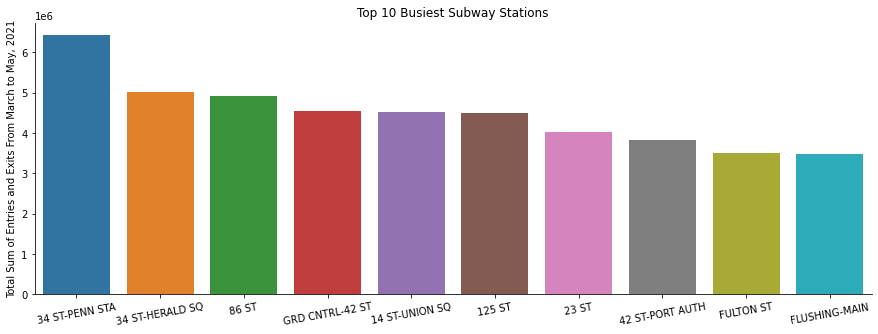

In [135]:
plt.figure(figsize=(15,5))
sns.barplot(x='STATION', y='SUM_DAILY', data=top_10_station)
plt.title("Top 10 Busiest Subway Stations")
plt.xticks(fontsize = '10', rotation = 10)
plt.yticks(fontsize = '10')
plt.xlabel("")
plt.ylabel("Total Sum of Entries and Exits From March to May, 2021", fontsize = '10')
sns.despine()
plt.savefig("top10_sum_daily_visit_staition.png", dpi = 200);

In [16]:
#Station avg
station_daily_avg = (station_daily.groupby(["STATION"], as_index=False)
                                  .agg({"SUM_DAILY":"mean", "ENTRIES_DAILY":"mean", "EXITS_DAILY":"mean"})
                                  .rename(columns={"SUM_DAILY": "AVG_DAILY"}))
top10_avg_staition = station_daily_avg.sort_values("AVG_DAILY", ascending=False).head(10)
top10_avg_staition

,STATION,AVG_DAILY,ENTRIES_DAILY,EXITS_DAILY
61,34 ST-PENN STA,69727.489130,29657.565217,40069.923913
59,34 ST-HERALD SQ,54514.217391,22948.554348,31565.663043
110,86 ST,53306.184783,23375.445652,29930.739130
233,GRD CNTRL-42 ST,49418.000000,20539.489130,28878.510870
14,14 ST-UNION SQ,49110.510870,20181.728261,28928.782609
9,125 ST,48846.076087,21924.891304,26921.184783
46,23 ST,43807.554348,20142.706522,23664.847826
68,42 ST-PORT AUTH,41696.967391,18327.902174,23369.065217
226,FULTON ST,38190.467391,16682.978261,21507.489130
217,FLUSHING-MAIN,37760.804348,18514.913043,19245.891304


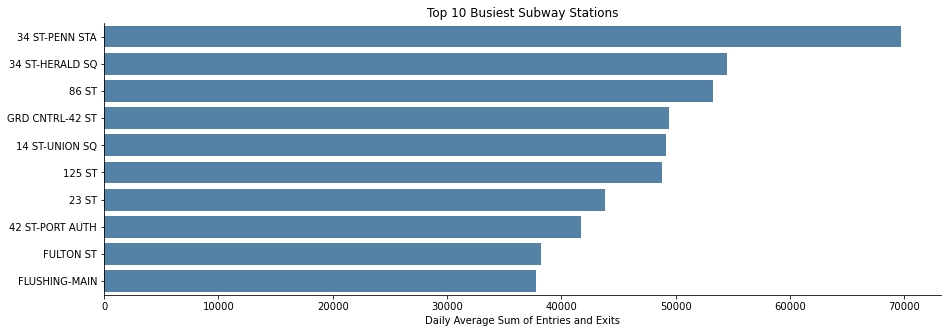

In [152]:
plt.figure(figsize=(15,5))
sns.barplot(x='AVG_DAILY', y='STATION', data=top10_avg_staition, color='steelblue')
plt.title("Top 10 Busiest Subway Stations")
plt.xticks(fontsize = '10')
plt.yticks(fontsize = '10')
plt.ylabel("")
plt.xlabel("Daily Average Sum of Entries and Exits", fontsize = '10')
sns.despine()
plt.savefig("images/top10_avg_daily_visit_staition.png", dpi = 400, facecolor = "w");

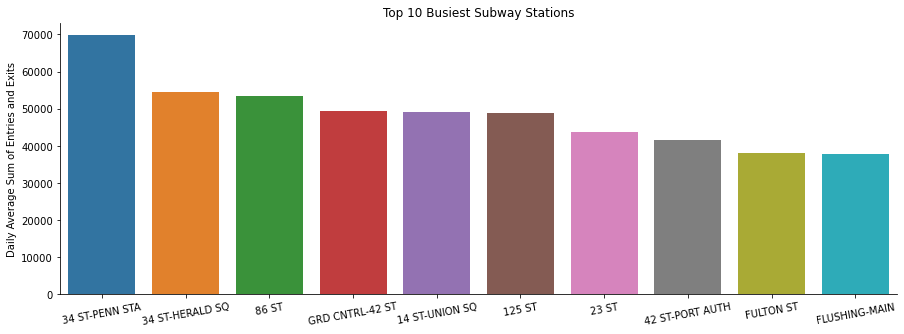

In [133]:
plt.figure(figsize=(15,5))
sns.barplot(x='STATION', y='AVG_DAILY', data=top10_avg_staition)
plt.title("Top 10 Busiest Subway Stations")
plt.xticks(fontsize = '10', rotation = 10)
plt.yticks(fontsize = '10')
plt.xlabel("")
plt.ylabel("Daily Average Sum of Entries and Exits", fontsize = '10')
sns.despine()
plt.savefig("top10_avg_daily_visit_staition_vertical.png", dpi = 200);

In [19]:
#weekday daily level
day_daily_sum = (daily.groupby(["DAY"], as_index=False)
                  .agg({"SUM_DAILY":"sum", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"}))
day_daily_sum

,DAY,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,0,43380826,21284345,22096481
1,1,43642200,21461126,22181074
2,2,43996700,21618621,22378079
3,3,43876746,21527535,22349211
4,4,44328977,21622311,22706666
5,5,29481694,13716089,15765605
6,6,21738153,9978823,11759330


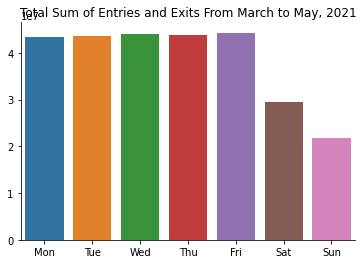

In [137]:
sns.barplot(x='DAY', y='SUM_DAILY', data=day_daily_sum)
plt.title("Total Sum of Entries and Exits From March to May, 2021")
plt.xticks(range(7), 
           ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], 
           fontsize = '10', rotation = 0)
plt.yticks(fontsize = '10')
plt.xlabel("")
plt.ylabel("")
sns.despine()
plt.savefig("total_visit_day.png", dpi = 200);

In [21]:
#sum_by_date level
sum_by_date = (daily.groupby(["DATE", "DAY"], as_index=False)
                        .agg({"SUM_DAILY":"sum", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"}))
sum_by_date

,DATE,DAY,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,2021-03-01,0,2837508,1393506,1444002
1,2021-03-02,1,3092470,1531328,1561142
2,2021-03-03,2,3244876,1605534,1639342
3,2021-03-04,3,3193006,1571550,1621456
4,2021-03-05,4,3221050,1581561,1639489
...,...,...,...,...,...
87,2021-05-27,3,3820790,1856052,1964738
88,2021-05-28,4,3664554,1769557,1894997
89,2021-05-29,5,2175792,1004847,1170945
90,2021-05-30,6,1686167,763204,922963


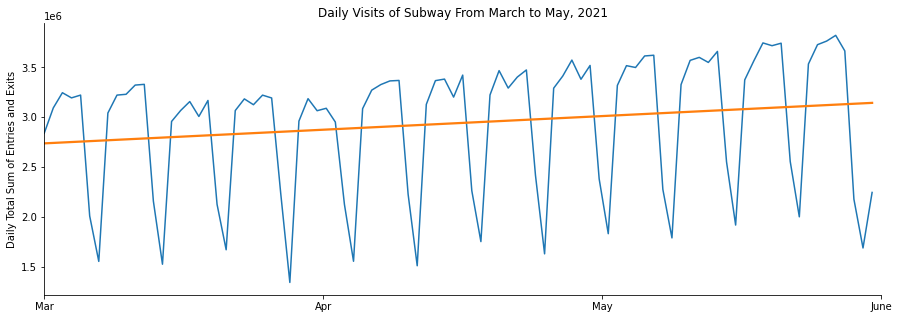

In [154]:
plt.figure(figsize=(15,5))
sns.lineplot(data=sum_by_date, x=sum_by_date.index, y="SUM_DAILY") 
sns.regplot(data=sum_by_date, x=sum_by_date.index, y="SUM_DAILY", ci=None, marker="")
plt.xticks(np.linspace(0,92,4), ['Mar', 'Apr', 'May', 'June'], fontsize = '10')
plt.title("Daily Visits of Subway From March to May, 2021")
plt.xlabel("")
plt.ylabel("Daily Total Sum of Entries and Exits")
sns.despine()
plt.savefig("images/total_visit_by_date.png", dpi = 400, facecolor = "w");


In [23]:
#avg day visits
day_avg = (sum_by_date.groupby(["DAY"], as_index=False)
                      .agg({"SUM_DAILY":"mean", "ENTRIES_DAILY":"mean", "EXITS_DAILY":"mean"})
                      .round()
                      .astype(int)
                      .rename(columns={"SUM_DAILY": "AVG_DAILY"}))
day_avg

,DAY,AVG_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,0,3098630,1520310,1578320
1,1,3357092,1650856,1706236
2,2,3384362,1662971,1721391
3,3,3375134,1655964,1719170
4,4,3409921,1663255,1746667
5,5,2267823,1055084,1212739
6,6,1672166,767602,904564


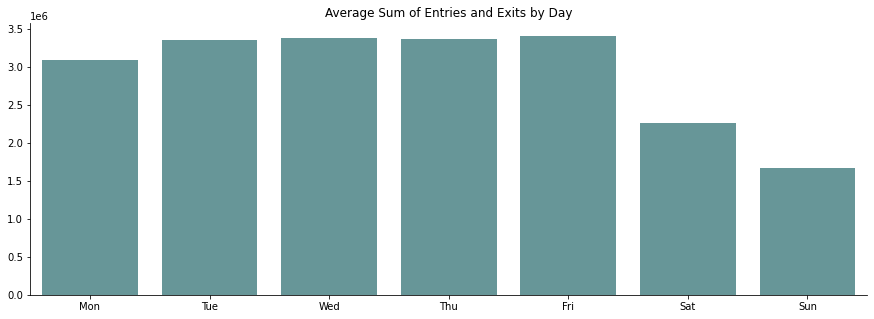

In [149]:
plt.figure(figsize=(15,5))
#sns.lineplot(x='DAY', y='AVG_DAILY', data=day_avg)
sns.barplot(x='DAY', y='AVG_DAILY', data=day_avg, color="cadetblue")
plt.title("Average Sum of Entries and Exits by Day")
plt.xticks(range(7), 
           ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], 
           fontsize = '10', rotation = 0)
plt.yticks(fontsize = '10')
plt.xlabel("")
plt.ylabel("", fontsize = '10')
sns.despine()
plt.savefig("images/avg_daily_visit_day.png", dpi = 400, facecolor='w');

# 3. Busiest Control Area and Hour

In [25]:
time_df = df.drop(["DESC","ENTRIES","EXITS","PRE_ENTRIES","PRE_EXITS","PRE_TIME"], axis = 1)
#https://www.learnersdictionary.com/qa/parts-of-the-day-early-morning-late-morning-etc
#b = [0,4,8,11,13,15,17,19,21,24]
#l = ['Late Night', 'Early Morning','Morning','Noon','Early Afternoon','Afternoon','Early Evening','Evening','Night']
#data is every 4 hours
b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Afternoon','Evening','Night']
time_df["PERIOD"] = pd.cut(time_df["DATE_TIME"].dt.hour, bins=b, labels=l, include_lowest=True).astype(str)
#need to change "category" type to "str" for faster groupby

In [26]:
time_df.head(10)

,CA,SCP,STATION,DATE,TIME,DATE_TIME,DAY,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,PERIOD
0,A002,02-00-00,59 ST,03/01/2021,07:00:00,2021-03-01 07:00:00,0,2,24,26,Early Morning
1,A002,02-00-00,59 ST,03/01/2021,11:00:00,2021-03-01 11:00:00,0,52,116,168,Morning
2,A002,02-00-00,59 ST,03/01/2021,15:00:00,2021-03-01 15:00:00,0,102,49,151,Afternoon
3,A002,02-00-00,59 ST,03/01/2021,19:00:00,2021-03-01 19:00:00,0,278,45,323,Evening
4,A002,02-00-00,59 ST,03/01/2021,23:00:00,2021-03-01 23:00:00,0,106,16,122,Night
5,A002,02-00-00,59 ST,03/02/2021,03:00:00,2021-03-02 03:00:00,1,9,1,10,Late Night
6,A002,02-00-00,59 ST,03/02/2021,07:00:00,2021-03-02 07:00:00,1,10,26,36,Early Morning
7,A002,02-00-00,59 ST,03/02/2021,11:00:00,2021-03-02 11:00:00,1,50,129,179,Morning
8,A002,02-00-00,59 ST,03/02/2021,15:00:00,2021-03-02 15:00:00,1,103,38,141,Afternoon
9,A002,02-00-00,59 ST,03/02/2021,19:00:00,2021-03-02 19:00:00,1,249,33,282,Evening


In [27]:
time_df.dtypes

CA                        object
SCP                       object
STATION                   object
DATE                      object
TIME                      object
DATE_TIME         datetime64[ns]
DAY                        int64
PERIOD_ENTRIES             int64
PERIOD_EXITS               int64
PERIOD_VISITS              int64
PERIOD                    object
dtype: object

In [28]:
#CA, DAY, PERIOD level by DATE
ca_df = (time_df.groupby(["CA","STATION","DATE","PERIOD", "DAY"], as_index=False)
                [["PERIOD_ENTRIES", "PERIOD_EXITS", "PERIOD_VISITS"]].sum())
ca_df

,CA,STATION,DATE,PERIOD,DAY,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS
0,A002,59 ST,03/01/2021,Afternoon,0,701,616,1317
1,A002,59 ST,03/01/2021,Early Morning,0,53,389,442
2,A002,59 ST,03/01/2021,Evening,0,2151,520,2671
3,A002,59 ST,03/01/2021,Morning,0,451,1681,2132
4,A002,59 ST,03/01/2021,Night,0,743,189,932
...,...,...,...,...,...,...,...,...
378104,TRAM2,RIT-ROOSEVELT,05/31/2021,Early Morning,0,2,4,6
378105,TRAM2,RIT-ROOSEVELT,05/31/2021,Evening,0,1084,9,1093
378106,TRAM2,RIT-ROOSEVELT,05/31/2021,Late Night,0,155,8,163
378107,TRAM2,RIT-ROOSEVELT,05/31/2021,Morning,0,102,0,102


In [264]:
period_dict = {'Late Night':0, 'Early Morning':1, 'Morning':2, 'Afternoon':3,'Evening':4,'Night':5}
period_df = (ca_df.groupby(["PERIOD", "DAY"], as_index=False)
                [["PERIOD_ENTRIES", "PERIOD_EXITS", "PERIOD_VISITS"]].sum())
period_df.PERIOD=period_df.PERIOD.map(period_dict)
period_df.sort_values("PERIOD_VISITS", ascending=False)

,PERIOD,DAY,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS
18,4,4,6770394,7224462,13994856
17,4,3,6678590,6944568,13623158
16,4,2,6689489,6909375,13598864
15,4,1,6689683,6895604,13585287
14,4,0,6635646,6879602,13515248
30,2,2,5277604,5624545,10902149
29,2,1,5243404,5609970,10853374
31,2,3,5236296,5577753,10814049
28,2,0,5218448,5573866,10792314
4,3,4,5184668,5413551,10598219


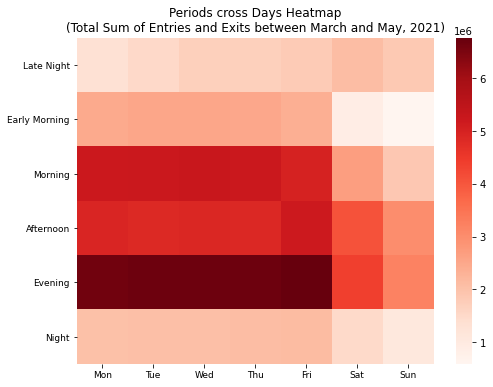

In [283]:
day_list = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
period_list = ['Late Night', 'Early Morning','Morning','Afternoon','Evening','Night']
plt.figure(figsize=(8,6))
sns.heatmap(period_df.pivot("PERIOD", "DAY", "PERIOD_ENTRIES"), cmap="Reds")
plt.xticks(np.arange(0.5,7.5,1), day_list, fontsize = '9', rotation = 0)
plt.yticks(np.arange(0.5,6.5,1), period_list, fontsize = '9', rotation = 0)
plt.xlabel("")
plt.ylabel("")
plt.title("Periods cross Days Heatmap\n(Total Sum of Entries and Exits between March and May, 2021)")
plt.savefig("images/day_period_heatmap.png", dpi = 500, facecolor ="w");

In [120]:
#AVG CA by day and hour
ca_when_df = (ca_df.groupby(["CA","STATION","DAY","PERIOD"], as_index=False)
              [["PERIOD_ENTRIES", "PERIOD_EXITS", "PERIOD_VISITS"]].mean())
ca_when_df["STA_CA"] = ca_when_df["CA"] + "@" + ca_when_df["STATION"]
ca_when_df["RATIO"] = ca_when_df["PERIOD_VISITS"] / ca_when_df["PERIOD_VISITS"].max()
ca_when_df

,CA,STATION,DAY,PERIOD,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,STA_CA,RATIO
0,A002,59 ST,0,Afternoon,1039.000000,633.714286,1672.714286,A002@59 ST,0.151705
1,A002,59 ST,0,Early Morning,154.357143,735.571429,889.928571,A002@59 ST,0.080711
2,A002,59 ST,0,Evening,2000.500000,504.785714,2505.285714,A002@59 ST,0.227215
3,A002,59 ST,0,Late Night,359.153846,163.307692,522.461538,A002@59 ST,0.047384
4,A002,59 ST,0,Morning,468.428571,1400.500000,1868.928571,A002@59 ST,0.169501
...,...,...,...,...,...,...,...,...,...
31488,TRAM2,RIT-ROOSEVELT,6,Early Morning,11.461538,2.923077,14.384615,TRAM2@RIT-ROOSEVELT,0.001305
31489,TRAM2,RIT-ROOSEVELT,6,Evening,751.076923,9.076923,760.153846,TRAM2@RIT-ROOSEVELT,0.068941
31490,TRAM2,RIT-ROOSEVELT,6,Late Night,171.769231,8.153846,179.923077,TRAM2@RIT-ROOSEVELT,0.016318
31491,TRAM2,RIT-ROOSEVELT,6,Morning,89.538462,4.846154,94.384615,TRAM2@RIT-ROOSEVELT,0.008560


In [122]:
ca_when_df.sort_values("PERIOD_VISITS", ascending=False).head(20)

,CA,STATION,DAY,PERIOD,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,STA_CA,RATIO
29419,R533,FLUSHING-MAIN,4,Evening,4758.461538,6267.615385,11026.076923,R533@FLUSHING-MAIN,1.000000
29401,R533,FLUSHING-MAIN,1,Evening,4636.076923,6202.461538,10838.538462,R533@FLUSHING-MAIN,0.982991
29407,R533,FLUSHING-MAIN,2,Evening,4544.000000,6151.692308,10695.692308,R533@FLUSHING-MAIN,0.970036
29413,R533,FLUSHING-MAIN,3,Evening,4454.846154,6108.692308,10563.538462,R533@FLUSHING-MAIN,0.958050
29395,R533,FLUSHING-MAIN,0,Evening,4448.642857,5970.285714,10418.928571,R533@FLUSHING-MAIN,0.944935
19321,PTH22,PATH NEW WTC,1,Evening,7187.307692,2152.769231,9340.076923,PTH22@PATH NEW WTC,0.847090
19327,PTH22,PATH NEW WTC,2,Evening,7148.153846,2111.076923,9259.230769,PTH22@PATH NEW WTC,0.839757
19339,PTH22,PATH NEW WTC,4,Evening,6374.538462,2506.461538,8881.000000,PTH22@PATH NEW WTC,0.805454
14054,N324,JKSN HT-ROOSVLT,4,Evening,3286.692308,5387.384615,8674.076923,N324@JKSN HT-ROOSVLT,0.786688
14048,N324,JKSN HT-ROOSVLT,3,Evening,3120.538462,5527.000000,8647.538462,N324@JKSN HT-ROOSVLT,0.784281


In [254]:
# **************final function**************
def team_arange(weeks, teams, outreaches):
    """
    Depends on the planned outreach weeks, the amount of the teams, and the goal of outreach times to
    return the list of the most busiest control areas with unduplicate periods separated by weekday and weekend.
    It means a control area will show up at most one weekday and at most one weekday at a certain period. 
    """
    ca_moment = ca_when_df[0:0]
    ca_period_list = []
    time_counts = {}
    ca_when_df_sort = ca_when_df.sort_values("PERIOD_VISITS", ascending=False).reset_index(drop=True)
    ca_when_df_sort["weekday"]= ca_when_df_sort.DAY.map(lambda x: "Yes" if x <= 5 else "No")

    for a in range(len(ca_when_df_sort)):
        ca_id = ca_when_df_sort.loc[a, "CA"] + ca_when_df_sort.loc[a, "weekday"] + ca_when_df_sort.loc[a, "PERIOD"]
        time_id = str(ca_when_df_sort.loc[a, "DAY"]) +  ca_when_df_sort.loc[a, "PERIOD"]
        if len(ca_moment) >= outreaches:
            break
        if time_id not in time_counts:
            time_counts[time_id] = 0
        if (ca_id not in ca_period_list) & (time_counts[time_id] < weeks * teams):
            ca_moment = ca_moment.append(ca_when_df_sort.loc[a])
            ca_period_list.append(ca_id)
            time_counts[time_id] += 1
    return ca_moment

team_arange(6, 3, 60)

,CA,STATION,DAY,PERIOD,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,STA_CA,RATIO,weekday
0,R533,FLUSHING-MAIN,4,Evening,4758.461538,6267.615385,11026.076923,R533@FLUSHING-MAIN,1.000000,Yes
5,PTH22,PATH NEW WTC,1,Evening,7187.307692,2152.769231,9340.076923,PTH22@PATH NEW WTC,0.847090,Yes
8,N324,JKSN HT-ROOSVLT,4,Evening,3286.692308,5387.384615,8674.076923,N324@JKSN HT-ROOSVLT,0.786688,Yes
12,R533,FLUSHING-MAIN,2,Morning,5237.538462,3168.923077,8406.461538,R533@FLUSHING-MAIN,0.762416,Yes
20,N506,34 ST-HERALD SQ,4,Evening,3750.692308,4119.230769,7869.923077,N506@34 ST-HERALD SQ,0.713756,Yes
21,R238,GRD CNTRL-42 ST,4,Evening,3169.384615,4545.076923,7714.461538,R238@GRD CNTRL-42 ST,0.699656,Yes
22,R528,JUNCTION BLVD,4,Evening,1880.307692,5701.461538,7581.769231,R528@JUNCTION BLVD,0.687622,Yes
25,PTH22,PATH NEW WTC,1,Morning,1323.461538,6230.615385,7554.076923,PTH22@PATH NEW WTC,0.685110,Yes
27,R533,FLUSHING-MAIN,4,Afternoon,3795.000000,3564.230769,7359.230769,R533@FLUSHING-MAIN,0.667439,Yes
28,N324,JKSN HT-ROOSVLT,4,Afternoon,3711.692308,3624.692308,7336.384615,N324@JKSN HT-ROOSVLT,0.665367,Yes


(array([35.,  0.,  0.,  0.,  0., 15.,  0.,  0.,  0., 10.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

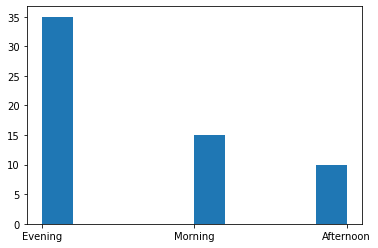

In [48]:
plt.hist(data=ca_when_df.sort_values("PERIOD_VISITS", ascending=False).head(60), x="PERIOD")

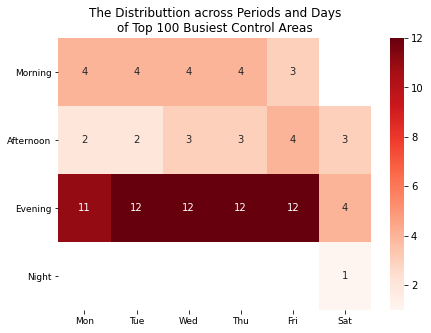

In [280]:
period_dict = {'Late Night':0, 'Early Morning':1, 'Morning':2, 'Afternoon':3,'Evening':4,'Night':5}
test_df = ca_when_df.sort_values("PERIOD_VISITS", ascending=False).head(100).groupby(["PERIOD", "DAY"], as_index=False).RATIO.count()
test_df.PERIOD=test_df.PERIOD.map(period_dict)
plt.figure(figsize=(7,5))
sns.heatmap(test_df.pivot("PERIOD", "DAY"), cmap="Reds", annot=True)
plt.xticks(np.arange(0.5,6.5,1), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat"], fontsize = '9', rotation = 0)
plt.yticks(np.arange(0.5,4.5,1), ['Morning','Afternoon','Evening','Night'], fontsize = '9', rotation = 0)
plt.xlabel("")
plt.ylabel("")
plt.title("The Distributtion across Periods and Days\nof Top 100 Busiest Control Areas")
plt.savefig("images/top100_ca_period_heatmap.png", dpi = 400, facecolor = "w");

In [50]:
ca_when_df[ca_when_df["STATION"] == "34 ST-PENN STA"].sort_values("PERIOD_VISITS", ascending=False).head(10)

,CA,STATION,DAY,PERIOD,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,STA_CA,RATIO
20935,R138,34 ST-PENN STA,4,Evening,2248.461538,4678.538462,6927.000000,34 ST-PENN STA: R138,0.628238
20923,R138,34 ST-PENN STA,2,Evening,2031.000000,4606.538462,6637.538462,34 ST-PENN STA: R138,0.601986
20929,R138,34 ST-PENN STA,3,Evening,2003.615385,4628.461538,6632.076923,34 ST-PENN STA: R138,0.601490
20917,R138,34 ST-PENN STA,1,Evening,1983.769231,4517.384615,6501.153846,34 ST-PENN STA: R138,0.589616
20911,R138,34 ST-PENN STA,0,Evening,2003.642857,4085.714286,6089.357143,34 ST-PENN STA: R138,0.552269
20919,R138,34 ST-PENN STA,1,Morning,3977.538462,1961.538462,5939.076923,34 ST-PENN STA: R138,0.538639
20931,R138,34 ST-PENN STA,3,Morning,3866.769231,2018.384615,5885.153846,34 ST-PENN STA: R138,0.533749
20925,R138,34 ST-PENN STA,2,Morning,3896.153846,1959.923077,5856.076923,34 ST-PENN STA: R138,0.531112
20913,R138,34 ST-PENN STA,0,Morning,3596.785714,1872.000000,5468.785714,34 ST-PENN STA: R138,0.495987
9392,N067,34 ST-PENN STA,4,Evening,1720.461538,3382.153846,5102.615385,34 ST-PENN STA: N067,0.462777


In [51]:
ca_df[ca_df.STATION == "FLUSHING-MAIN"].groupby("CA").PERIOD_VISITS.mean()

CA
R533    6334.459746
R534    1914.315678
Name: PERIOD_VISITS, dtype: float64

In [52]:
for day in range(7):
    print(ca_when_df[ca_when_df.DAY == day].sort_values("PERIOD_VISITS", ascending=False).head(10))
    

          CA          STATION  DAY     PERIOD  PERIOD_ENTRIES  PERIOD_EXITS  \
29395   R533    FLUSHING-MAIN    0    Evening     4448.642857   5970.285714   
14030   N324  JKSN HT-ROOSVLT    0    Evening     3047.642857   5147.571429   
29397   R533    FLUSHING-MAIN    0    Morning     4966.357143   3139.142857   
19315  PTH22     PATH NEW WTC    0    Evening     6014.357143   1937.285714   
29185   R528    JUNCTION BLVD    0    Evening     1694.642857   5746.714286   
29393   R533    FLUSHING-MAIN    0  Afternoon     3678.714286   3522.928571   
19317  PTH22     PATH NEW WTC    0    Morning     1363.571429   5525.714286   
24103   R238  GRD CNTRL-42 ST    0    Evening     2855.214286   3761.785714   
14032   N324  JKSN HT-ROOSVLT    0    Morning     4694.142857   1904.357143   
15962   N506  34 ST-HERALD SQ    0    Evening     3365.785714   3036.500000   

       PERIOD_VISITS                 STA_CA     RATIO  
29395   10418.928571    FLUSHING-MAIN: R533  0.944935  
14030    8195.2142

In [53]:
ca_when_df[(ca_when_df.DAY == 0) & (ca_when_df.PERIOD == "Morning")].sort_values("PERIOD_VISITS", ascending=False).head(10)

,CA,STATION,DAY,PERIOD,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,STA_CA,RATIO
29397,R533,FLUSHING-MAIN,0,Morning,4966.357143,3139.142857,8105.500000,FLUSHING-MAIN: R533,0.735121
19317,PTH22,PATH NEW WTC,0,Morning,1363.571429,5525.714286,6889.285714,PATH NEW WTC: PTH22,0.624817
14032,N324,JKSN HT-ROOSVLT,0,Morning,4694.142857,1904.357143,6598.500000,JKSN HT-ROOSVLT: N324,0.598445
24105,R238,GRD CNTRL-42 ST,0,Morning,1874.785714,4336.428571,6211.214286,GRD CNTRL-42 ST: R238,0.563320
20913,R138,34 ST-PENN STA,0,Morning,3596.785714,1872.000000,5468.785714,34 ST-PENN STA: R138,0.495987
25029,R258,125 ST,0,Morning,1952.000000,3074.142857,5026.142857,125 ST: R258,0.455841
24693,R249,86 ST,0,Morning,529.214286,4233.928571,4763.142857,86 ST: R249,0.431989
15712,N501,47-50 STS ROCK,0,Morning,370.785714,4215.714286,4586.500000,47-50 STS ROCK: N501,0.415968
18645,PTH03,JOURNAL SQUARE,0,Morning,3742.642857,736.214286,4478.857143,JOURNAL SQUARE: PTH03,0.406206
29187,R528,JUNCTION BLVD,0,Morning,3141.428571,1273.428571,4414.857143,JUNCTION BLVD: R528,0.400401


In [54]:
#loop to get top 10 of different periods of different days 
period_day_df = ca_when_df[0:0]
#.drop(['CA', 'STATION', 'PERIOD_ENTRIES', 'PERIOD_EXITS'], axis=1)
for day in range(7):
    for period in ['Morning','Afternoon','Evening']:
        period_day_df = period_day_df.append(ca_when_df[(ca_when_df.DAY == day) & (ca_when_df.PERIOD == period)]
                                            .sort_values("PERIOD_VISITS", ascending=False)
                                            .head(1))
period_day_df

,CA,STATION,DAY,PERIOD,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,STA_CA,RATIO
29397,R533,FLUSHING-MAIN,0,Morning,4966.357143,3139.142857,8105.500000,FLUSHING-MAIN: R533,0.735121
29393,R533,FLUSHING-MAIN,0,Afternoon,3678.714286,3522.928571,7201.642857,FLUSHING-MAIN: R533,0.653146
29395,R533,FLUSHING-MAIN,0,Evening,4448.642857,5970.285714,10418.928571,FLUSHING-MAIN: R533,0.944935
29403,R533,FLUSHING-MAIN,1,Morning,4868.538462,3034.000000,7902.538462,FLUSHING-MAIN: R533,0.716714
29399,R533,FLUSHING-MAIN,1,Afternoon,3689.846154,3498.692308,7188.538462,FLUSHING-MAIN: R533,0.651958
29401,R533,FLUSHING-MAIN,1,Evening,4636.076923,6202.461538,10838.538462,FLUSHING-MAIN: R533,0.982991
29409,R533,FLUSHING-MAIN,2,Morning,5237.538462,3168.923077,8406.461538,FLUSHING-MAIN: R533,0.762416
29405,R533,FLUSHING-MAIN,2,Afternoon,3638.230769,3455.307692,7093.538462,FLUSHING-MAIN: R533,0.643342
29407,R533,FLUSHING-MAIN,2,Evening,4544.000000,6151.692308,10695.692308,FLUSHING-MAIN: R533,0.970036
29415,R533,FLUSHING-MAIN,3,Morning,5142.846154,3083.692308,8226.538462,FLUSHING-MAIN: R533,0.746098


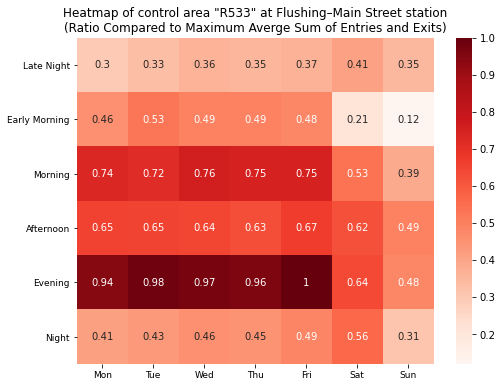

In [282]:
r533_df = ca_when_df[ca_when_df["CA"] == "R533"].sort_values("RATIO", ascending=False)
period_dict = {'Late Night':0, 'Early Morning':1, 'Morning':2, 'Afternoon':3,'Evening':4,'Night':5}
r533_df.PERIOD=r533_df.PERIOD.map(period_dict)
day_list = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
period_list = ['Late Night', 'Early Morning','Morning','Afternoon','Evening','Night']
plt.figure(figsize=(8,6))
sns.heatmap(r533_df.pivot("PERIOD", "DAY", "RATIO"), cmap="Reds", annot=True)
plt.xticks(np.arange(0.5,7.5,1), day_list, fontsize = '9', rotation = 0)
plt.yticks(np.arange(0.5,6.5,1), period_list, fontsize = '9', rotation = 0)
plt.xlabel("")
plt.ylabel("")
plt.title("Heatmap of control area \"R533\" at Flushing–Main Street station\n(Ratio Compared to Maximum Averge Sum of Entries and Exits)")
plt.savefig("images/r533_heatmap.png", dpi = 500, facecolor ="w");

In [41]:
period_day_df = ca_when_df[0:0]
#.drop(['CA', 'STATION', 'PERIOD_ENTRIES', 'PERIOD_EXITS'], axis=1)
for day in range(7):
    for period in ['Morning','Afternoon','Evening']:
        period_day_df = period_day_df.append(ca_when_df[(ca_when_df.DAY == day) & (ca_when_df.PERIOD == period)]
                                            .sort_values("PERIOD_VISITS", ascending=False)
                                            .head(10))
period_day_df


,CA,STATION,DAY,PERIOD,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,STA_CA,RATIO
29397,R533,FLUSHING-MAIN,0,Morning,4966.357143,3139.142857,8105.500000,FLUSHING-MAIN: R533,73.512094
19317,PTH22,PATH NEW WTC,0,Morning,1363.571429,5525.714286,6889.285714,PATH NEW WTC: PTH22,62.481749
14032,N324,JKSN HT-ROOSVLT,0,Morning,4694.142857,1904.357143,6598.500000,JKSN HT-ROOSVLT: N324,59.844495
24105,R238,GRD CNTRL-42 ST,0,Morning,1874.785714,4336.428571,6211.214286,GRD CNTRL-42 ST: R238,56.332042
20913,R138,34 ST-PENN STA,0,Morning,3596.785714,1872.000000,5468.785714,34 ST-PENN STA: R138,49.598654
...,...,...,...,...,...,...,...,...,...
19351,PTH22,PATH NEW WTC,6,Evening,2088.000000,1545.461538,3633.461538,PATH NEW WTC: PTH22,32.953348
9908,N083,W 4 ST-WASH SQ,6,Evening,1237.307692,2357.153846,3594.461538,W 4 ST-WASH SQ: N083,32.599641
24139,R238,GRD CNTRL-42 ST,6,Evening,1613.000000,1914.846154,3527.846154,GRD CNTRL-42 ST: R238,31.995479
25063,R258,125 ST,6,Evening,1359.692308,2101.692308,3461.384615,125 ST: R258,31.392712


In [72]:
ca_when_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31493 entries, 0 to 31492
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CA              31493 non-null  object 
 1   STATION         31493 non-null  object 
 2   DAY             31493 non-null  int64  
 3   PERIOD          31493 non-null  object 
 4   PERIOD_ENTRIES  31493 non-null  float64
 5   PERIOD_EXITS    31493 non-null  float64
 6   PERIOD_VISITS   31493 non-null  float64
 7   STA_CA          31493 non-null  object 
 8   RATIO           31493 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 2.2+ MB


In [88]:
for day in range(7):
    for period in ['Morning','Afternoon','Evening', 'Night']:
        print(ca_when_df[(ca_when_df.DAY == day) & (ca_when_df.PERIOD == period)].sort_values("PERIOD_VISITS",ascending=False).head(10))

          CA          STATION  DAY   PERIOD  PERIOD_ENTRIES  PERIOD_EXITS  \
29397   R533    FLUSHING-MAIN    0  Morning     4966.357143   3139.142857   
19317  PTH22     PATH NEW WTC    0  Morning     1363.571429   5525.714286   
14032   N324  JKSN HT-ROOSVLT    0  Morning     4694.142857   1904.357143   
24105   R238  GRD CNTRL-42 ST    0  Morning     1874.785714   4336.428571   
20913   R138   34 ST-PENN STA    0  Morning     3596.785714   1872.000000   
25029   R258           125 ST    0  Morning     1952.000000   3074.142857   
24693   R249            86 ST    0  Morning      529.214286   4233.928571   
15712   N501   47-50 STS ROCK    0  Morning      370.785714   4215.714286   
18645  PTH03   JOURNAL SQUARE    0  Morning     3742.642857    736.214286   
29187   R528    JUNCTION BLVD    0  Morning     3141.428571   1273.428571   

       PERIOD_VISITS                 STA_CA     RATIO  
29397    8105.500000    FLUSHING-MAIN: R533  0.735121  
19317    6889.285714    PATH NEW WTC: PT

          CA          STATION  DAY   PERIOD  PERIOD_ENTRIES  PERIOD_EXITS  \
29425   R533    FLUSHING-MAIN    5  Evening     3466.615385   3554.000000   
15992   N506  34 ST-HERALD SQ    5  Evening     3035.230769   3339.692308   
14060   N324  JKSN HT-ROOSVLT    5  Evening     2462.750000   3789.916667   
29215   R528    JUNCTION BLVD    5  Evening     1637.692308   4455.461538   
23461   R221   14 ST-UNION SQ    5  Evening     2189.000000   3654.769231   
19345  PTH22     PATH NEW WTC    5  Evening     3025.923077   2404.384615   
746     A034   14 ST-UNION SQ    5  Evening     2096.692308   3206.384615   
9902    N083   W 4 ST-WASH SQ    5  Evening     1671.846154   3287.230769   
5450    H009       BEDFORD AV    5  Evening     2208.307692   2552.692308   
24133   R238  GRD CNTRL-42 ST    5  Evening     1926.461538   2729.307692   

       PERIOD_VISITS                 STA_CA     RATIO  
29425    7020.615385    FLUSHING-MAIN: R533  0.636728  
15992    6374.923077  34 ST-HERALD SQ: N

In [121]:
md_table = []

for period in ['Morning','Afternoon','Evening', 'Night']:
    md_table.append(period)
    for day in range(7):
        temp_df = ca_when_df[(ca_when_df.DAY == day) & (ca_when_df.PERIOD == period)].sort_values("PERIOD_VISITS", ascending=False).head(10)
        temp_df.index=[''] * len(temp_df)
#str(day) + "/" + period + ":" + 
        md_table.append(("<br />").join(list(temp_df.STA_CA + "(" + temp_df.RATIO.round(2).astype(str) + ")")))
#print(period + " uses:" + "|".join(md_table))
    print("|".join(md_table))
    md_table=[]

Morning|R533@FLUSHING-MAIN(0.74)<br />PTH22@PATH NEW WTC(0.62)<br />N324@JKSN HT-ROOSVLT(0.6)<br />R238@GRD CNTRL-42 ST(0.56)<br />R138@34 ST-PENN STA(0.5)<br />R258@125 ST(0.46)<br />R249@86 ST(0.43)<br />N501@47-50 STS ROCK(0.42)<br />PTH03@JOURNAL SQUARE(0.41)<br />R528@JUNCTION BLVD(0.4)|R533@FLUSHING-MAIN(0.72)<br />PTH22@PATH NEW WTC(0.69)<br />N324@JKSN HT-ROOSVLT(0.6)<br />R238@GRD CNTRL-42 ST(0.6)<br />R138@34 ST-PENN STA(0.54)<br />R258@125 ST(0.49)<br />N501@47-50 STS ROCK(0.46)<br />R249@86 ST(0.45)<br />R528@JUNCTION BLVD(0.43)<br />PTH03@JOURNAL SQUARE(0.42)|R533@FLUSHING-MAIN(0.76)<br />PTH22@PATH NEW WTC(0.65)<br />N324@JKSN HT-ROOSVLT(0.61)<br />R238@GRD CNTRL-42 ST(0.6)<br />R138@34 ST-PENN STA(0.53)<br />R258@125 ST(0.47)<br />N501@47-50 STS ROCK(0.46)<br />R249@86 ST(0.45)<br />R528@JUNCTION BLVD(0.44)<br />PTH03@JOURNAL SQUARE(0.41)|R533@FLUSHING-MAIN(0.75)<br />PTH22@PATH NEW WTC(0.65)<br />N324@JKSN HT-ROOSVLT(0.61)<br />R238@GRD CNTRL-42 ST(0.6)<br />R138@34 ST-